In [1]:
import os
from copy import deepcopy
from tqdm import tqdm
from datetime import date, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import RandomSampler
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs you can use: {max_n_jobs}")

Maximum n_jobs you can use: 4


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("NMXLNT_df.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
print(df["Location"].unique())
df.head()

['BAY MAU.csv' 'BTLVT.csv' 'CAU NGA.csv' 'TU SON.csv' 'YENSO.csv']


,level_0,datetime,flow_in,flow_out1,flow_out2,flow_out3,temp,ph,tss,do,...,Location_prev_12,minute_prev_12,sin_minute_prev_12,hour_prev_12,sin_hour_prev_12,day_prev_12,sin_day_prev_12,month_prev_12,sin_month_prev_12,abnormal
0,1,2024-01-01 12:05:00,312.09,4.70,4.30,17.61,27.52,7.15,7.60,NaN,...,BAY MAU.csv,5,0.500000,0,0.0,1,0.201299,1,0.5,False
1,2,2024-01-01 12:10:00,304.32,4.71,4.41,18.72,27.63,7.15,7.65,NaN,...,BAY MAU.csv,10,0.866025,0,0.0,1,0.201299,1,0.5,False
2,3,2024-01-01 12:15:00,304.53,4.62,4.58,18.97,27.63,7.16,7.56,NaN,...,BAY MAU.csv,15,1.000000,0,0.0,1,0.201299,1,0.5,False
3,4,2024-01-01 12:20:00,310.44,4.57,4.68,18.19,27.63,7.16,7.67,NaN,...,BAY MAU.csv,20,0.866025,0,0.0,1,0.201299,1,0.5,False
4,5,2024-01-01 12:25:00,308.93,132.15,113.86,525.37,27.63,7.17,7.69,NaN,...,BAY MAU.csv,25,0.500000,0,0.0,1,0.201299,1,0.5,False


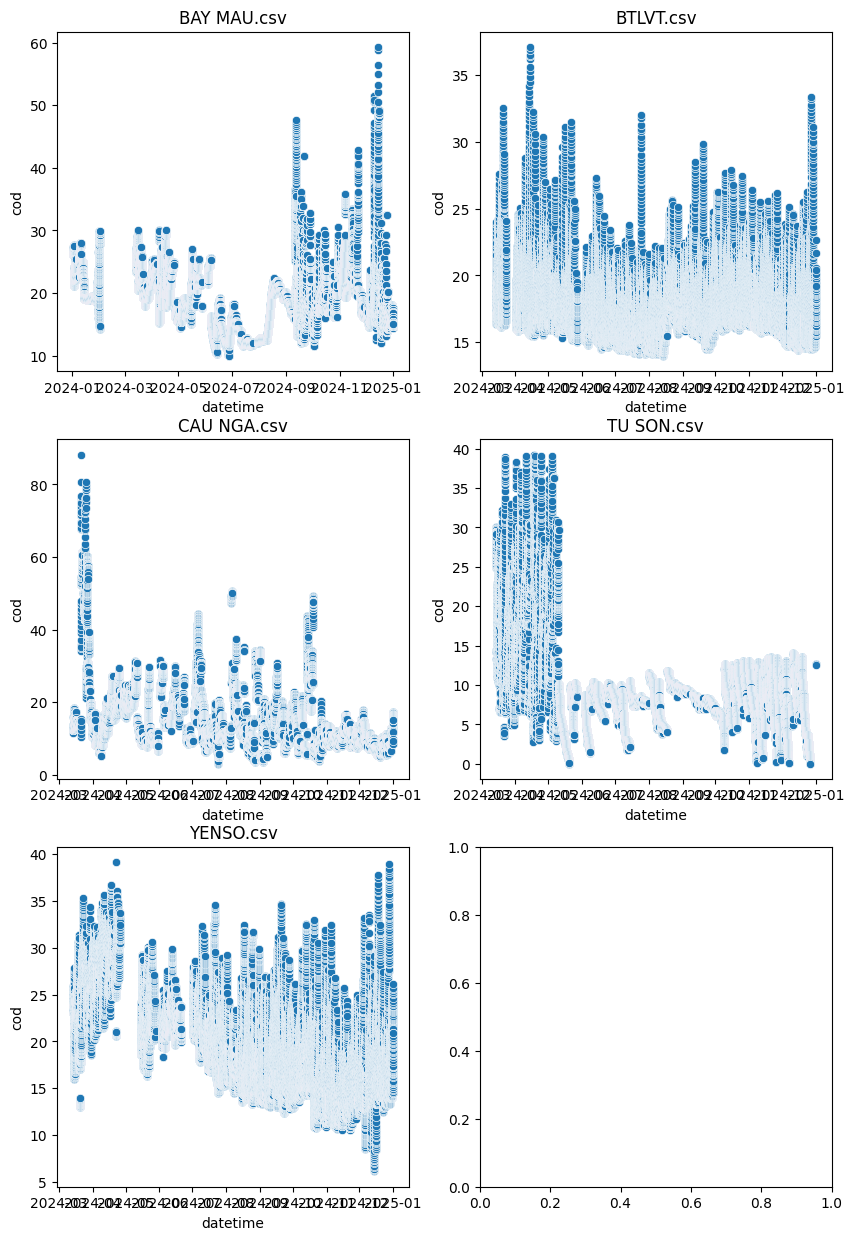

In [3]:
# try to plot cod against time in all data
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    x, y = inx // 2, inx % 2
    sns.scatterplot(df[df["Location"] == loc], x = "datetime", y = "cod", ax = ax[x][y])
    ax[x][y].set_title(loc)
plt.show()

Make CV split & compare with baseline

In [4]:
def create_cv_split(df, features_used, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / (train.shape[0] + test.shape[0]))
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_with_val(df, features_used, cv = 5):
    X_train_arr = []
    X_val_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_val_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i - 1].reset_index().drop("index", axis = 1))
        val = deepcopy(df[df["datetime"].dt.month == start_month + i - 1].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / (train.shape[0] + test.shape[0]))
        X_train_arr.append(train[features_used])
        X_val_arr.append(val[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_val_arr.append(val["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_val_arr, X_test_arr, Y_train_arr, Y_val_arr, Y_test_arr

def create_cv_split_location(df, features_used, loc, cv = 5):
    df = df[df["Location"] == loc].reset_index().drop("index", axis = 1)
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_diff(df, features_used, time_diff = 4, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train[f"cod_diff_{time_diff}"])
        Y_test_arr.append(test[f"cod_diff_{time_diff}"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_with_info(df, features_used, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    info_train_arr = []
    info_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
        info_train_arr.append(train[["datetime", "Location"]])
        info_test_arr.append((test[["datetime", "Location"]]))
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, info_train_arr, info_test_arr

Make the model and finetune

In [5]:
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": 200,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log = True),
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "enable_categorical": True,
        "random_state": 101
    }

    xgbr = XGBRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        xgbr.fit(X_train, Y_train)
        Y_pred = xgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_lightgbm(trial):
    params = {
        "n_estimators": 200,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state": 101
    }

    lgbr = LGBMRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        lgbr.fit(X_train, Y_train)
        Y_pred = lgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "random_seed": 37
    }

    cbr = CatBoostRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        cbr.fit(X_train, Y_train)
        Y_pred = cbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_xgboost_with_val(trial):
    params = {
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log = True),
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "enable_categorical": True,
        "random_state": 101,
        #"early_stopping_rounds": 20
    }

    xgbr = XGBRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_val, X_test = X_train_arr[i], X_val_arr[i], X_test_arr[i]
        Y_train, Y_val, Y_test = Y_train_arr[i], Y_val_arr[i], Y_test_arr[i]
        xgbr.fit(
            X_train, 
            Y_train,
            #eval_set=[(X_val, Y_val)],
            verbose=False
        )
        Y_pred = xgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_catboost_with_val(trial):
    params = {
        "iterations": 1000,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "random_seed": 37,
        #"early_stopping_rounds": 20
    }

    cbr = CatBoostRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_val, X_test = X_train_arr[i], X_val_arr[i], X_test_arr[i]
        Y_train, Y_val, Y_test = Y_train_arr[i], Y_val_arr[i], Y_test_arr[i]
        cbr.fit(
            X_train, 
            Y_train,
            #eval_set=[(X_val, Y_val)],
            verbose=False
        )
        Y_pred = cbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

In [6]:
default_n_trials = 100
default_n_jobs = -1

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSE:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best MSE:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSLE:', study.best_value)
    return study.best_params

In [7]:
#### NOTE: All info about lags used will be saved here
lag_used = [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]

In [8]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_minute", "sin_hour", "sin_day", "sin_month"]
# features_used = [c for c in df.columns if "prev" in c and df[c].dtypes in ["int64", "float64"]]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# baseline: using last k hours to predict
baseline_score = 0
for i in range(5):
    baseline_score += np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2))
baseline_score /= 5
print(baseline_score)

for loc in df["Location"].unique():
    print(loc)
    temp_df = deepcopy(df[df["Location"] == loc])
    X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(temp_df, features_used)
    for i in range(5):
        print(i, np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2)))

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

3.1116485294275606
BAY MAU.csv
0 0.24606320126003584
1 4.113666255109288
2 2.0578124996898635
3 2.134433013935609
4 4.849039638931622
BTLVT.csv
0 2.0001539773722232
1 2.3070406960627614
2 2.3916359862287324
3 2.2260039185715668
4 2.9273573873019485
CAU NGA.csv
0 4.662899062941014
1 3.2898535466626653
2 5.101619286873792
3 1.046633455526751
4 1.3304944443445952
TU SON.csv
0 0.769248806845777
1 0.23320403283712607
2 1.3746508568272784
3 1.917692093490895
4 1.5519128946417566
YENSO.csv
0 3.82755873328261
1 4.860900721136991
2 4.527551796481887
3 4.092907161020668
4 5.202359098216686


In [9]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_study", 
    f"xgboost_study"
)
# best is 2.85 (with remove of very high cod)
# best is 2.88 (without remove of very high cod)
# best is 2.81 (with remove of abnormal cod)

Conduct hyperparam opt for XGBoost


[I 2025-05-15 22:13:58,768] Using an existing study with name 'xgboost_study' instead of creating a new one.
[I 2025-05-15 22:15:45,749] Trial 42 finished with value: 3.709111309244103 and parameters: {'max_depth': 2, 'learning_rate': 0.03413008987154959, 'subsample': 0.6756979129074306, 'colsample_bytree': 0.0005509510512045068, 'min_child_weight': 1}. Best is trial 11 with value: 2.8184940139445454.
[I 2025-05-15 22:18:14,791] Trial 40 finished with value: 3.076395022060445 and parameters: {'max_depth': 6, 'learning_rate': 0.015044180137526448, 'subsample': 0.8741652158812191, 'colsample_bytree': 0.13060700732247366, 'min_child_weight': 6}. Best is trial 11 with value: 2.8184940139445454.
[I 2025-05-15 22:19:22,759] Trial 43 finished with value: 3.1300394920696175 and parameters: {'max_depth': 5, 'learning_rate': 0.037797405807198134, 'subsample': 0.3826253170268753, 'colsample_bytree': 0.05608533419344963, 'min_child_weight': 1}. Best is trial 11 with value: 2.8184940139445454.
[I 2

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.027476499389535284, 'subsample': 0.32056998400669445, 'colsample_bytree': 0.8231576487459638, 'min_child_weight': 4}
Best RMSE: 2.8070691888402886


In [ ]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_study", 
    f"lightgbm_study",
) 
# best is 2.96 (with remove of very high cod)
# best is 2.88 (without remove of very high cod)

Conduct hyperparam opt for LightGBM


[I 2025-05-16 14:41:19,896] Using an existing study with name 'lightgbm_study' instead of creating a new one.
[I 2025-05-16 14:43:45,241] Trial 78 finished with value: 2.937464030811841 and parameters: {'learning_rate': 0.026891136505040974, 'num_leaves': 103, 'subsample': 0.06514227632950284, 'colsample_bytree': 0.5119289072090687, 'min_data_in_leaf': 49}. Best is trial 29 with value: 2.8774316745140096.
[I 2025-05-16 14:44:01,161] Trial 79 finished with value: 3.0285571432540506 and parameters: {'learning_rate': 0.03596955355018793, 'num_leaves': 182, 'subsample': 0.3317034196610978, 'colsample_bytree': 0.27393377323885293, 'min_data_in_leaf': 73}. Best is trial 29 with value: 2.8774316745140096.
[I 2025-05-16 14:46:30,255] Trial 76 finished with value: 3.0618259460880894 and parameters: {'learning_rate': 0.011138544099612171, 'num_leaves': 417, 'subsample': 0.7308815205295577, 'colsample_bytree': 0.450538563434572, 'min_data_in_leaf': 26}. Best is trial 29 with value: 2.877431674514

Best hyperparameters: {'learning_rate': 0.021662438235617167, 'num_leaves': 26, 'subsample': 0.464314612143296, 'colsample_bytree': 0.6346201495714126, 'min_data_in_leaf': 60}
Best MSE: 2.8441130603464426


In [10]:
best_params_catboost = optimize_catboost(
    f"catboost_study", 
    f"catboost_study"
)
# best is this one, about 2.81 RMSE (with remove of very high cod)
# best is 2.859 (without remove of very high cod)

Conduct hyperparam opt for CatBoost


[I 2025-05-16 15:28:39,970] A new study created in RDB with name: catboost_study
[I 2025-05-16 15:30:41,576] Trial 3 finished with value: 2.836317077234901 and parameters: {'learning_rate': 0.03632641945797796, 'depth': 3, 'subsample': 0.4021445609253474, 'colsample_bylevel': 0.3488933743322395, 'min_data_in_leaf': 135}. Best is trial 3 with value: 2.836317077234901.
[I 2025-05-16 15:31:48,937] Trial 1 finished with value: 2.8256861805495026 and parameters: {'learning_rate': 0.02915708987889864, 'depth': 4, 'subsample': 0.4871957243133761, 'colsample_bylevel': 0.5148709493534626, 'min_data_in_leaf': 255}. Best is trial 1 with value: 2.8256861805495026.
[I 2025-05-16 15:34:48,102] Trial 0 finished with value: 2.818162935422395 and parameters: {'learning_rate': 0.06706659534287483, 'depth': 8, 'subsample': 0.30939940826897744, 'colsample_bylevel': 0.5318808466119714, 'min_data_in_leaf': 380}. Best is trial 0 with value: 2.818162935422395.
[I 2025-05-16 15:36:10,317] Trial 4 finished with

Best hyperparameters: {'learning_rate': 0.02661480879319175, 'depth': 8, 'subsample': 0.2766755265758157, 'colsample_bylevel': 0.6447401250955432, 'min_data_in_leaf': 111}
Best RMSLE: 2.7891876532671587


Testing on best configuration

In [8]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [10]:
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": 101
}
best_params_xgboost = get_best_params_from_file("xgboost_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    features = xgbr.feature_names_in_.tolist()
    features_i = xgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

{'cod_prev_4': 0.7675765007734299,
 'cod_prev_4.5': 0.7750747054815292,
 'cod_prev_5': 0.5181990042328835,
 'cod_prev_5.5': 0.39630843698978424,
 'cod_prev_6': 0.11051885038614273,
 'cod_prev_6.5': 0.11038623843342066,
 'cod_prev_7': 0.102955580689013,
 'cod_prev_7.5': 0.10912062600255013,
 'cod_prev_8': 0.08748907875269651,
 'cod_prev_8.5': 0.06894937250763178,
 'cod_prev_9': 0.0572414924390614,
 'cod_prev_9.5': 0.04988920036703348,
 'cod_prev_10': 0.05646253377199173,
 'cod_prev_10.5': 0.05630965018644929,
 'cod_prev_11': 0.06776340771466494,
 'cod_prev_11.5': 0.0835864869877696,
 'cod_prev_12': 0.0854248907417059,
 'temp_prev_4': 0.023909576470032334,
 'temp_prev_4.5': 0.024576199240982533,
 'temp_prev_5': 0.02661006897687912,
 'temp_prev_5.5': 0.04773808061145246,
 'temp_prev_6': 0.020285947481170297,
 'temp_prev_6.5': 0.018311796244233847,
 'temp_prev_7': 0.015489466954022646,
 'temp_prev_7.5': 0.01633007009513676,
 'temp_prev_8': 0.02675036061555147,
 'temp_prev_8.5': 0.023489475

In [11]:
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": 101,
    "importance_type": "gain"
}
best_params_lightgbm = get_best_params_from_file("lightgbm_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    lgbr.fit(X_train, Y_train)
    features = lgbr.feature_names_in_.tolist()
    features_i = lgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# seems to pick up time features not as good as past 4 hours features

{'cod_prev_4': 585075667.7663574,
 'cod_prev_4.5': 277859655.21398926,
 'cod_prev_5': 150441915.789917,
 'cod_prev_5.5': 31770340.710266113,
 'cod_prev_6': 18043459.035949707,
 'cod_prev_6.5': 1639246.6130981445,
 'cod_prev_7': 4326822.40045166,
 'cod_prev_7.5': 5492767.601928711,
 'cod_prev_8': 9685693.662719727,
 'cod_prev_8.5': 6646359.065673828,
 'cod_prev_9': 4539395.814025879,
 'cod_prev_9.5': 3044983.719848633,
 'cod_prev_10': 3357722.791442871,
 'cod_prev_10.5': 3384417.226867676,
 'cod_prev_11': 2325912.3514404297,
 'cod_prev_11.5': 7275291.398376465,
 'cod_prev_12': 14023374.471740723,
 'temp_prev_4': 2686663.198364258,
 'temp_prev_4.5': 1895820.7994384766,
 'temp_prev_5': 2167592.8884887695,
 'temp_prev_5.5': 1424548.108581543,
 'temp_prev_6': 775390.2854003906,
 'temp_prev_6.5': 554901.6004638672,
 'temp_prev_7': 789548.7113037109,
 'temp_prev_7.5': 608988.8710327148,
 'temp_prev_8': 642909.1511230469,
 'temp_prev_8.5': 993302.7507324219,
 'temp_prev_9': 1242408.5760498047,

In [12]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
best_params_catboost = get_best_params_from_file("catboost_study")
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    cbr.fit(X_train, Y_train)
    features = cbr.feature_names_
    features_i = cbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# can pick up a combination of both past cod and tss, not good at picking up ph, temp

{'cod_prev_4': 178.78808000827263,
 'cod_prev_4.5': 57.62176748994224,
 'cod_prev_5': 24.99156790141273,
 'cod_prev_5.5': 15.205636472066189,
 'cod_prev_6': 14.789985497850664,
 'cod_prev_6.5': 9.37197874360415,
 'cod_prev_7': 4.579581195034356,
 'cod_prev_7.5': 7.065538744331855,
 'cod_prev_8': 10.698726572280568,
 'cod_prev_8.5': 5.469096148934979,
 'cod_prev_9': 6.867086219658637,
 'cod_prev_9.5': 4.82938100542486,
 'cod_prev_10': 5.553465053320091,
 'cod_prev_10.5': 5.431948001306902,
 'cod_prev_11': 4.665872927357957,
 'cod_prev_11.5': 7.64108055792393,
 'cod_prev_12': 13.150034412739025,
 'temp_prev_4': 1.2268133090085565,
 'temp_prev_4.5': 1.236406467573342,
 'temp_prev_5': 1.135210546687568,
 'temp_prev_5.5': 1.047077684504836,
 'temp_prev_6': 1.0137643295638537,
 'temp_prev_6.5': 0.6928771540427563,
 'temp_prev_7': 0.8392410301102236,
 'temp_prev_7.5': 0.7742371516453515,
 'temp_prev_8': 1.1789260091347065,
 'temp_prev_8.5': 1.3434886383929976,
 'temp_prev_9': 1.14593657484857

Try to train with only previous CODs insteads

In [13]:
features_used = [f"cod_prev_{i}" for i in lag_used] 
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [14]:
best_params_xgboost_only_cod = optimize_xgboost(
    f"xgboost_study_only_cod",
    f"xgboost_study_only_cod",
)
# seems to not improve?, might be because using all 4-12 hours cod before does not work => use 4-8 hours before
# still 2.87 in the best version that only use cod, worse than best version that use all features
# seems to better by including other features than just time features

Conduct hyperparam opt for XGBoost


[I 2025-05-19 19:34:44,425] A new study created in RDB with name: xgboost_study_only_cod
[I 2025-05-19 19:36:34,654] Trial 0 finished with value: 2.8511833739491803 and parameters: {'max_depth': 5, 'learning_rate': 0.018866985110938032, 'subsample': 0.8979418133406883, 'colsample_bytree': 0.2891977871773975, 'min_child_weight': 2}. Best is trial 0 with value: 2.8511833739491803.
[I 2025-05-19 19:36:34,844] Trial 2 finished with value: 2.9188101757420957 and parameters: {'max_depth': 5, 'learning_rate': 0.013730723933862685, 'subsample': 0.3079279162233199, 'colsample_bytree': 0.12189031520260785, 'min_child_weight': 2}. Best is trial 0 with value: 2.8511833739491803.
[I 2025-05-19 19:37:47,057] Trial 3 finished with value: 2.93220632397635 and parameters: {'max_depth': 9, 'learning_rate': 0.06664358902831226, 'subsample': 0.1305120380357936, 'colsample_bytree': 0.8351822103763417, 'min_child_weight': 10}. Best is trial 0 with value: 2.8511833739491803.
[I 2025-05-19 19:37:53,928] Trial

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.021113172224339886, 'subsample': 0.7639223697122295, 'colsample_bytree': 0.6503135696820396, 'min_child_weight': 5}
Best RMSE: 2.8300174228450907


In [15]:
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": 101
}
best_params_xgboost_only_cod = get_best_params_from_file("xgboost_study_only_cod")
for p in best_params_xgboost_only_cod:
    params[p] = best_params_xgboost_only_cod[p]

feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    features = xgbr.feature_names_in_.tolist()
    features_i = xgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

{'cod_prev_4': 1.434742957353592,
 'cod_prev_4.5': 1.312369391322136,
 'cod_prev_5': 0.7622954100370407,
 'cod_prev_5.5': 0.2518702447414398,
 'cod_prev_6': 0.10817231237888336,
 'cod_prev_6.5': 0.1289325449615717,
 'cod_prev_7': 0.17255358397960663,
 'cod_prev_7.5': 0.12539740465581417,
 'cod_prev_8': 0.12966924533247948,
 'cod_prev_8.5': 0.09649493545293808,
 'cod_prev_9': 0.0613702111877501,
 'cod_prev_9.5': 0.060202715918421745,
 'cod_prev_10': 0.05825855769217014,
 'cod_prev_10.5': 0.050567812751978636,
 'cod_prev_11': 0.07029361836612225,
 'cod_prev_11.5': 0.08050312846899033,
 'cod_prev_12': 0.0963059812784195}

In [16]:
# try to train with less values of cod
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]] 
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [17]:
best_params_xgboost_only_cod_truncated = optimize_xgboost(
    f"xgboost_study_only_cod_truncated",
    f"xgboost_study_only_cod_truncated",
) 

Conduct hyperparam opt for XGBoost


[I 2025-05-19 20:50:46,398] A new study created in RDB with name: xgboost_study_only_cod_truncated
[I 2025-05-19 20:51:31,678] Trial 2 finished with value: 3.096563945631501 and parameters: {'max_depth': 2, 'learning_rate': 0.011046826016236707, 'subsample': 0.9224824757835784, 'colsample_bytree': 0.15188604347511625, 'min_child_weight': 2}. Best is trial 2 with value: 3.096563945631501.
[I 2025-05-19 20:52:37,213] Trial 4 finished with value: 2.858103870472104 and parameters: {'max_depth': 4, 'learning_rate': 0.018372210729507062, 'subsample': 0.2629492585571232, 'colsample_bytree': 0.425923541906854, 'min_child_weight': 5}. Best is trial 4 with value: 2.858103870472104.
[I 2025-05-19 20:52:57,283] Trial 3 finished with value: 2.861759486851404 and parameters: {'max_depth': 8, 'learning_rate': 0.013882475420404609, 'subsample': 0.25383988470112295, 'colsample_bytree': 0.9499979567863063, 'min_child_weight': 2}. Best is trial 4 with value: 2.858103870472104.
[I 2025-05-19 20:53:10,255]

Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.03597596543562308, 'subsample': 0.2184847990022733, 'colsample_bytree': 0.5279540638797015, 'min_child_weight': 1}
Best RMSE: 2.849567630113846


Try to using only some past hours cod and some non-cod features

In [18]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 5, 5.5, 6, 7, 7.5, 8, 8.5, 9, 11.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)
# not really good, try to use an extended version

In [19]:
best_params_lightgbm_best_comb = optimize_lightgbm(
    f"lightgbm_study_best_comb",
    f"lightgbm_study_best_comb"
)

Conduct hyperparam opt for LightGBM


[I 2025-05-19 21:28:00,711] A new study created in RDB with name: lightgbm_study_best_comb
[I 2025-05-19 21:29:15,896] Trial 3 finished with value: 2.9537891488268864 and parameters: {'learning_rate': 0.07032087187121167, 'num_leaves': 283, 'subsample': 0.5046438740765153, 'colsample_bytree': 0.19319783384180428, 'min_data_in_leaf': 81}. Best is trial 3 with value: 2.9537891488268864.
[I 2025-05-19 21:29:54,060] Trial 2 finished with value: 3.12568552000523 and parameters: {'learning_rate': 0.05270915883706528, 'num_leaves': 381, 'subsample': 0.9013365938181872, 'colsample_bytree': 0.9951394355756837, 'min_data_in_leaf': 52}. Best is trial 3 with value: 2.9537891488268864.
[I 2025-05-19 21:29:56,812] Trial 1 finished with value: 3.030889867646485 and parameters: {'learning_rate': 0.041036496712426235, 'num_leaves': 396, 'subsample': 0.23315237880530965, 'colsample_bytree': 0.8556190861675582, 'min_data_in_leaf': 37}. Best is trial 3 with value: 2.9537891488268864.
[I 2025-05-19 21:30:3

Best hyperparameters: {'learning_rate': 0.014607205456100465, 'num_leaves': 25, 'subsample': 0.24521994440458644, 'colsample_bytree': 0.436038220253738, 'min_data_in_leaf': 61}
Best MSE: 2.828867030321321


In [20]:
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": 101
}
for p in best_params_lightgbm_best_comb:
    params[p] = best_params_lightgbm_best_comb[p]

feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    lgbr.fit(X_train, Y_train)
    features = lgbr.feature_names_in_.tolist()
    features_i = lgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances

{'cod_prev_4': 3952,
 'cod_prev_4.5': 1920,
 'cod_prev_5': 1317,
 'cod_prev_5.5': 1546,
 'cod_prev_6': 786,
 'cod_prev_7': 391,
 'cod_prev_7.5': 607,
 'cod_prev_8': 709,
 'cod_prev_8.5': 763,
 'cod_prev_9': 1367,
 'cod_prev_11.5': 1528,
 'cod_prev_12': 1930,
 'ph_prev_4': 2486,
 'tss_prev_4': 2114,
 'sin_day': 1259,
 'sin_month': 1325}

In [8]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 5, 5.5, 9, 11.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)
# not really good, try to use an extended version

In [9]:
best_params_lightgbm_best_comb_truncated = optimize_lightgbm(
    f"lightgbm_study_best_comb_truncated",
    f"lightgbm_study_best_comb_truncated"
)

Conduct hyperparam opt for LightGBM


[I 2025-05-20 20:00:56,215] Using an existing study with name 'lightgbm_study_best_comb_truncated' instead of creating a new one.
[I 2025-05-20 20:01:54,021] Trial 102 finished with value: 2.872156367484652 and parameters: {'learning_rate': 0.013486829290696091, 'num_leaves': 222, 'subsample': 0.17698803360331017, 'colsample_bytree': 0.5533948143426004, 'min_data_in_leaf': 98}. Best is trial 4 with value: 2.7992230091687653.
[I 2025-05-20 20:02:19,455] Trial 104 finished with value: 2.825131363959993 and parameters: {'learning_rate': 0.03320596438607627, 'num_leaves': 66, 'subsample': 0.65421977062025, 'colsample_bytree': 0.22586983184162118, 'min_data_in_leaf': 55}. Best is trial 4 with value: 2.7992230091687653.
[I 2025-05-20 20:02:54,638] Trial 101 finished with value: 3.0589316477350397 and parameters: {'learning_rate': 0.053288512447749854, 'num_leaves': 501, 'subsample': 0.6166310115446054, 'colsample_bytree': 0.9238829866290188, 'min_data_in_leaf': 89}. Best is trial 4 with valu

Best hyperparameters: {'learning_rate': 0.02335573575257493, 'num_leaves': 83, 'subsample': 0.23341655413792073, 'colsample_bytree': 0.3466264008037244, 'min_data_in_leaf': 40}
Best MSE: 2.7992230091687653


Try to look at special combination based on catboost

In [9]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [10]:
best_params_catboost_best_comb = optimize_catboost(
    f"catboost_study_best_comb",
    f"catboost_study_best_comb"
)

Conduct hyperparam opt for CatBoost


[I 2025-05-20 23:24:06,961] A new study created in RDB with name: catboost_study_best_comb
[I 2025-05-20 23:25:06,611] Trial 0 finished with value: 2.90429934874763 and parameters: {'learning_rate': 0.07459053581223983, 'depth': 1, 'subsample': 0.5873219056893686, 'colsample_bylevel': 0.27054544651149504, 'min_data_in_leaf': 108}. Best is trial 0 with value: 2.90429934874763.
[I 2025-05-20 23:25:37,514] Trial 1 finished with value: 2.773526149826394 and parameters: {'learning_rate': 0.09679419453516303, 'depth': 3, 'subsample': 0.5277697772260674, 'colsample_bylevel': 0.37381341621813874, 'min_data_in_leaf': 111}. Best is trial 1 with value: 2.773526149826394.
[I 2025-05-20 23:25:42,614] Trial 2 finished with value: 2.832578475413407 and parameters: {'learning_rate': 0.028894948636459944, 'depth': 2, 'subsample': 0.9545140582953995, 'colsample_bylevel': 0.5112324687519226, 'min_data_in_leaf': 325}. Best is trial 1 with value: 2.773526149826394.
[I 2025-05-20 23:26:24,567] Trial 4 finis

Best hyperparameters: {'learning_rate': 0.04350448370467416, 'depth': 9, 'subsample': 0.21026195052704033, 'colsample_bylevel': 0.4002879713989891, 'min_data_in_leaf': 408}
Best RMSLE: 2.721952924497896


In [11]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
best_params_catboost_best_comb = get_best_params_from_file("catboost_study_best_comb")
for p in best_params_catboost_best_comb:
    params[p] = best_params_catboost_best_comb[p]

feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    cbr.fit(X_train, Y_train)
    features = cbr.feature_names_
    features_i = cbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances

{'cod_prev_4': 120.18269643010359,
 'cod_prev_4.5': 63.11922330628174,
 'cod_prev_5': 34.43944274734858,
 'cod_prev_5.5': 17.326208820877774,
 'cod_prev_6': 16.158595226765797,
 'cod_prev_6.5': 12.755944478394834,
 'cod_prev_7': 11.412382522156268,
 'cod_prev_7.5': 8.508383353757932,
 'cod_prev_8': 7.804232990077929,
 'cod_prev_8.5': 9.393168121329284,
 'cod_prev_9': 6.711669246569395,
 'cod_prev_9.5': 7.924187715481709,
 'cod_prev_10': 7.3006827765540905,
 'cod_prev_10.5': 7.513067215731645,
 'cod_prev_11': 8.615549624046587,
 'cod_prev_11.5': 15.575063558226612,
 'cod_prev_12': 18.359075258340706,
 'sin_day': 26.92022427199344,
 'sin_month': 37.14322330026144,
 'tss_prev_4': 17.70613705699098,
 'tss_prev_4.5': 13.566772795023427,
 'tss_prev_5': 13.3117394449397,
 'tss_prev_5.5': 18.252329738746624}

Try to use all features

In [ ]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                [f"nh4_prev_{i}" for i in lag_used] + \
                [f"do_prev_{i}" for i in lag_used] + \
                [f"po4_prev_{i}" for i in lag_used] + \
                [f"total_n_prev_{i}" for i in lag_used] + \
                [f"total_p_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"] 

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [ ]:
best_params_catboost_extended = optimize_catboost(
    f"catboost_study_extended", 
    f"catboost_study_extended"
)

Try to look at specific region

In [ ]:
baymau_df = df[df["Location"] == "BAY MAU.csv"].reset_index().drop("index", axis = 1)

In [ ]:
features_used = [f"cod_prev_{i}" for i in range(4, 9)]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(baymau_df, features_used)

# baseline
baseline_score = 0
for i in range(5):
    baseline_score += np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2))
baseline_score / 5

In [ ]:
best_params_xgboost_only_cod_baymau = optimize_xgboost(
    f"xgboost_study_only_cod_baymau",
    f"xgboost_study_only_cod_baymau",
)

In [ ]:
btlvt_df = df[df["Location"] == "BTLVT.csv"].reset_index().drop("index", axis = 1)

In [ ]:
features_used = [f"cod_prev_{i}" for i in range(4, 9)]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(btlvt_df, features_used)

# baseline
baseline_score = 0
for i in range(5):
    baseline_score += np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2))
baseline_score / 5

In [ ]:
best_params_xgboost_only_cod_btlvt = optimize_xgboost(
    f"xgboost_study_only_cod_btlvt",
    f"xgboost_study_only_cod_btlvt",
)

In [ ]:
caunga_df = df[df["Location"] == "CAU NGA.csv"].reset_index().drop("index", axis = 1)

In [ ]:
features_used = [f"cod_prev_{i}" for i in range(4, 9)]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(caunga_df, features_used)

# baseline
baseline_score = 0
for i in range(5):
    baseline_score += np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2))
baseline_score / 5

In [ ]:
best_params_xgboost_only_cod_caunga = optimize_xgboost(
    f"xgboost_study_only_cod_caunga",
    f"xgboost_study_only_cod_caunga",
)

Analyze error from model

Best model that only use COD

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["hour", "day", "month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, info_train_arr, info_test_arr = create_cv_split_with_info(df, features_used)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_cod:
    params[p] = best_params_catboost_only_cod[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[0], X_test_arr[0]
Y_train, Y_test = Y_train_arr[0], Y_test_arr[0]
info_train, info_test = info_train_arr[0], info_test_arr[0]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    x, y = inx // 2, inx % 2
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_cod:
    params[p] = best_params_catboost_only_cod[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[1], X_test_arr[1]
Y_train, Y_test = Y_train_arr[1], Y_test_arr[1]
info_train, info_test = info_train_arr[1], info_test_arr[1]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    x, y = inx // 2, inx % 2
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_cod:
    params[p] = best_params_catboost_only_cod[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[2], X_test_arr[2]
Y_train, Y_test = Y_train_arr[2], Y_test_arr[2]
info_train, info_test = info_train_arr[2], info_test_arr[2]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    x, y = inx // 2, inx % 2
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_cod:
    params[p] = best_params_catboost_only_cod[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[3], X_test_arr[3]
Y_train, Y_test = Y_train_arr[3], Y_test_arr[3]
info_train, info_test = info_train_arr[3], info_test_arr[3]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    x, y = inx // 2, inx % 2
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_cod:
    params[p] = best_params_catboost_only_cod[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[4], X_test_arr[4]
Y_train, Y_test = Y_train_arr[4], Y_test_arr[4]
info_train, info_test = info_train_arr[4], info_test_arr[4]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    x, y = inx // 2, inx % 2
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

Best model that only use last 4 hours features

In [ ]:
features_used = ["cod_prev_4", "ph_prev_4", "tss_prev_4", "month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, info_train_arr, info_test_arr = create_cv_split_with_info(df, features_used)

In [ ]:
params = {
    "iterations": 100,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_4h:
    params[p] = best_params_catboost_only_4h[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[0], X_test_arr[0]
Y_train, Y_test = Y_train_arr[0], Y_test_arr[0]
info_train, info_test = info_train_arr[0], info_test_arr[0]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 100,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_4h:
    params[p] = best_params_catboost_only_4h[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[1], X_test_arr[1]
Y_train, Y_test = Y_train_arr[1], Y_test_arr[1]
info_train, info_test = info_train_arr[1], info_test_arr[1]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 100,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_4h:
    params[p] = best_params_catboost_only_4h[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[2], X_test_arr[2]
Y_train, Y_test = Y_train_arr[2], Y_test_arr[2]
info_train, info_test = info_train_arr[2], info_test_arr[2]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 100,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_4h:
    params[p] = best_params_catboost_only_4h[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[3], X_test_arr[3]
Y_train, Y_test = Y_train_arr[3], Y_test_arr[3]
info_train, info_test = info_train_arr[3], info_test_arr[3]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 100,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_only_4h:
    params[p] = best_params_catboost_only_4h[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[4], X_test_arr[4]
Y_train, Y_test = Y_train_arr[4], Y_test_arr[4]
info_train, info_test = info_train_arr[4], info_test_arr[4]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

Best model that use some combination of both

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["hour", "day", "month"] + \
                ["tss_prev_4", "tss_prev_5"]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, info_train_arr, info_test_arr = create_cv_split_with_info(df, features_used)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_special_comb:
    params[p] = best_params_catboost_special_comb[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[0], X_test_arr[0]
Y_train, Y_test = Y_train_arr[0], Y_test_arr[0]
info_train, info_test = info_train_arr[0], info_test_arr[0]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_special_comb:
    params[p] = best_params_catboost_special_comb[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[1], X_test_arr[1]
Y_train, Y_test = Y_train_arr[1], Y_test_arr[1]
info_train, info_test = info_train_arr[1], info_test_arr[1]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_special_comb:
    params[p] = best_params_catboost_special_comb[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[2], X_test_arr[2]
Y_train, Y_test = Y_train_arr[2], Y_test_arr[2]
info_train, info_test = info_train_arr[2], info_test_arr[2]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_special_comb:
    params[p] = best_params_catboost_special_comb[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[3], X_test_arr[3]
Y_train, Y_test = Y_train_arr[3], Y_test_arr[3]
info_train, info_test = info_train_arr[3], info_test_arr[3]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost_special_comb:
    params[p] = best_params_catboost_special_comb[p]

cbr = CatBoostRegressor(**params)

X_train, X_test = X_train_arr[4], X_test_arr[4]
Y_train, Y_test = Y_train_arr[4], Y_test_arr[4]
info_train, info_test = info_train_arr[4], info_test_arr[4]
cbr.fit(X_train, Y_train)
Y_pred = cbr.predict(X_test)
temp = pd.DataFrame({
    "Location": info_test["Location"],
    "datetime": info_test["datetime"],
    "true_cod": Y_test,
    "pred_cod": Y_pred
})

print(root_mean_squared_error(Y_test, Y_pred))
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    temp_df = temp[temp["Location"] == loc]
    x, y = inx // 2, inx % 2
    print(loc, root_mean_squared_error(temp_df["true_cod"], temp_df["pred_cod"]))
    ax[x][y].scatter(temp_df["datetime"], temp_df["true_cod"], color = "green")
    ax[x][y].scatter(temp_df["datetime"], temp_df["pred_cod"], color = "red")
    ax[x][y].set_title(loc)

Try to increase number of estimator + adding validation based on good set of features for the model

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_minute", "sin_hour", "sin_day", "sin_month"]
X_train_arr, X_val_arr, X_test_arr, Y_train_arr, Y_val_arr, Y_test_arr = create_cv_split_with_val(df, features_used)

In [ ]:
best_params_xgboost_with_val = optimize_xgboost(
    f"xgboost_study_with_val",
    f"xgboost_study_with_val",
    objective_xgboost_with_val
)
# slightly worse than model with only 200 trees

In [ ]:
best_params_catboost_with_val = optimize_catboost(
    f"catboost_study_with_val",
    f"catboost_study_with_val",
    objective_catboost_with_val
) # not better than original model with 200 trees

Try to combine best 3 models

In [12]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_xgboost = get_best_params_from_file("xgboost_study")
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": 101
}
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

# train list of models
xgbr_arr = [XGBRegressor(**params)] * 5
Y_pred_xgboost_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr_arr[i].fit(X_train, Y_train)
    Y_pred_xgboost_arr.append(xgbr_arr[i].predict(X_test))

In [13]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 5, 5.5, 9, 11.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_lightgbm = get_best_params_from_file("lightgbm_study_best_comb_truncated")
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": 101
}
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

# train list of models
lgbr_arr = [LGBMRegressor(**params)] * 5
Y_pred_lightgbm_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr_arr[i].fit(X_train, Y_train)
    Y_pred_lightgbm_arr.append(lgbr_arr[i].predict(X_test))

In [14]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_catboost = get_best_params_from_file("catboost_study_best_comb")
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": 37
}
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

# train list of models
cbr_arr = [CatBoostRegressor(**params)] * 5
Y_pred_catboost_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    cbr_arr[i].fit(X_train, Y_train)
    Y_pred_catboost_arr.append(cbr_arr[i].predict(X_test))

In [15]:
best_cv_rmse = float("inf")
best_alpha = -1
best_beta = -1
for alpha in tqdm([0.01 * k for k in range(101)]):
    for beta in [0.01 * l for l in range(101)]:
        cv_rmse = 0
        for i in range(5):
            Y_pred =  alpha * Y_pred_catboost_arr[i] + (1 - alpha) * beta * Y_pred_lightgbm_arr[i] + (1 - alpha) * (1 - beta) * Y_pred_xgboost_arr[i]
            rmse = root_mean_squared_error(Y_test_arr[i], Y_pred)
            cv_rmse += rmse
        cv_rmse /= 5
        if cv_rmse < best_cv_rmse:
            best_cv_rmse = cv_rmse 
            best_alpha = alpha
            best_beta = beta
print(best_alpha, best_beta, best_cv_rmse)

100%|██████████| 101/101 [01:08<00:00,  1.47it/s]

0.91 0.1 2.721257110801748
